In [47]:
import os
import re
import pickle
import spacy
import datetime
import pandas as pd
import numpy as np

from tqdm import tqdm
import pandas_datareader as pdr

datetime.datetime(1970, 1, 1, 0, 0)

In [2]:
processed_dir = r'D:\data\kaggle_news\processed'
news_text_pklfile = 'dic_all_news_text.pkl'

In [61]:
df_basel_risk_norms = pd.read_csv('risk_mean_basel_risk_norms.csv')
lst_BRN_lower = [x.strip().lower() for x in df_basel_risk_norms.source]
df_basel_risk_norms.index =lst_BRN_lower

In [62]:

df_basel_risk_norms.head()

,source,rating
america,America,8.921053
antarctic,Antarctic,38.099338
australia,Australia,-25.805195
boston,Boston,-14.824324
california,California,-21.959184


In [125]:
df_basel_risk_norms.loc['america','rating']

8.921052631578947

In [3]:
dic_news_text = pickle.load(open(os.path.join(processed_dir, news_text_pklfile), 'rb'))

In [8]:
nlp = spacy.load('en_core_web_lg')

<b> (Caution) Below for loop takes 5 hours. Use dic_rick_word_in_news.pkl file! </b>

In [17]:
riskword_news_file = 'dic_risk_word_in_news.pkl'

if os.path.exists(riskword_news_file):
    print(f'Loading {riskword_news_file} ...')
    dic_risk_word_in_news = pickle.load(open(riskword_news_file, 'rb'))
else:
    dic_risk_word_in_news = {}
    for uuid, dic_text in tqdm(dic_news_text.items()):
        news_text = dic_text['text']
        # split text into words using re
        doc = nlp(news_text)
        tokens = [token for token in doc]
        lemma_lower = [token.lemma_.lower() for token in tokens]
        risk_words = [x for x in lemma_lower if x in lst_BRN_lower]
        if len(risk_words) > 0:
            dic_risk_word_in_news[uuid] = risk_words

100%|██████████| 306188/306188 [5:14:02<00:00, 16.25it/s]   


In [18]:
if not os.path.exists(riskword_news_file):
    pickle.dump(dic_risk_word_in_news, open(riskword_news_file, 'wb'))

In [114]:
len(dic_risk_word_in_news)

253887

In [20]:
news_meta_file = 'dic_all_news.pkl'
dic_news_meta = pickle.load(open(os.path.join(processed_dir, news_meta_file), 'rb'))

In [21]:
first_key = next(iter(dic_news_meta))

In [23]:
dic_news_meta[first_key]

{'organizations': [],
 'author': '',
 'url': 'https://www.cnbc.com/2018/01/03/emerging-markets-are-set-for-an-even-bigger-rally-in-2018-says-one-technician.html',
 'ord_in_thread': 0,
 'title': 'Emerging markets are set for an even bigger rally in 2018, says one technician',
 'locations': [],
 'highlightText': '',
 'language': 'english',
 'persons': [],
 'external_links': [],
 'published': '2018-01-03T15:00:00.000+02:00',
 'crawled': '2018-01-03T15:34:36.006+02:00',
 'highlightTitle': '',
 'word_cnt': 303}

In [24]:
dic_uuid_pubdate = {key: val['published'] for key, val in dic_news_meta.items()}

In [25]:
len(dic_uuid_pubdate)

306188

In [269]:
df_pubdate = pd.Series(dic_uuid_pubdate)
df_risk = pd.Series(dic_risk_word_in_news)
df_all = pd.concat([df_pubdate, df_risk], axis=1)
df_all.columns = ['pubdate', 'risk_word']
df_all.set_index('pubdate', inplace=True, drop=True)
df_all.index = pd.PeriodIndex(df_all.index, freq='D')
# df_all.reset_index(inplace=True)
df_all.head(10)

,risk_word
pubdate,
2018-01-03,"[relationship, fall]"
2018-01-03,[fuel]
2018-01-03,"[people, people, facebook]"
2018-01-02,"[television, fire, orange, fire, winter, olymp..."
2018-01-01,"[death, death, pilot, crash, australia]"
2018-01-03,"[government, government, government, criminal,..."
2018-01-03,"[energy, barrel, gas, gas, gas, exposure, gas,..."
2018-01-02,"[industry, america, california, chicago, chicago]"
2018-01-03,"[technology, tank, learning, technology, indus..."


In [271]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2018,5,31)
vix = pdr.DataReader('VIXCLS', 'fred', start, end).dropna()

In [272]:
vix.index = pd.PeriodIndex(vix.index, freq='D')
df_all = pd.merge(df_all, vix, how='outer', left_index=True, right_index=True)
df_all = df_all.loc['2018-01-01':]
df_all = df_all.bfill().ffill()

In [55]:
text = 'test'
# isinstance(text, list) 
isinstance(text, np.ndarray)

False

In [56]:
def get_risk_word(text):
    if isinstance(text, list):
        return int(len(text))
    return text

df_all['num_words'] = df_all['risk_word'].apply(lambda x: get_risk_word(x))

In [278]:
df_all.head()

,risk_word,VIXCLS,num_words
pubdate,,,
2018-01-01,"[death, death, pilot, crash, australia]",9.77,5
2018-01-01,"[slide, fall, street]",9.77,3
2018-01-01,"[doll, doll, space, science, doll, science, te...",9.77,11
2018-01-01,"[machinery, street, criminal, government]",9.77,4
2018-01-01,"[army, military, air, army, army, army, warfar...",9.77,13


In [304]:
df_all.to_parquet('df_all.parquet', compression='snappy')

In [58]:
df_all = pd.read_parquet('df_all.parquet')
df_all.index = pd.PeriodIndex([datetime.datetime.utcfromtimestamp(0) + datetime.timedelta(x) for x in df_all.index], freq='D')
df_all.index.name = 'pubdate'

In [59]:
df_all

,risk_word,VIXCLS,num_words,risk_score
pubdate,,,,
2018-01-01,"[death, death, pilot, crash, australia]",9.77,5,223.670163
2018-01-01,"[slide, fall, street]",9.77,3,NaN
2018-01-01,"[doll, doll, space, science, doll, science, te...",9.77,11,NaN
2018-01-01,"[machinery, street, criminal, government]",9.77,4,65.228758
2018-01-01,"[army, military, air, army, army, army, warfar...",9.77,13,268.806432
...,...,...,...,...
2018-06-01,"[professor, government, industry]",15.43,3,NaN
2018-06-01,"[government, government]",15.43,2,NaN
2018-06-01,"[california, street, human, street]",15.43,4,NaN


In [63]:
def get_risk_word_score(text):
    
    if isinstance(text, list) or isinstance(text, np.ndarray):
        lst_positive_score = []
        for x in text:
            score = df_basel_risk_norms.loc[x, 'rating']
            if score > 50:
                lst_positive_score.append(score)
        if len(lst_positive_score) > 0:
            return sum(lst_positive_score)
        # score = sum([df_basel_risk_norms.loc[x, 'rating'] for x in text])
    return None

df_all['risk_score'] = df_all['risk_word'].apply(lambda x: get_risk_word_score(x))


In [64]:
df_all.head()

,risk_word,VIXCLS,num_words,risk_score
pubdate,,,,
2018-01-01,"[death, death, pilot, crash, australia]",9.77,5,223.670163
2018-01-01,"[slide, fall, street]",9.77,3,NaN
2018-01-01,"[doll, doll, space, science, doll, science, te...",9.77,11,NaN
2018-01-01,"[machinery, street, criminal, government]",9.77,4,65.228758
2018-01-01,"[army, military, air, army, army, army, warfar...",9.77,13,268.806432


In [65]:
df_all2 = df_all.dropna().sort_index()
df_all2 = df_all2.groupby('pubdate').agg({'num_words':['sum','count'],'risk_score':'sum', 'VIXCLS': 'mean'})

In [66]:
df_all2.columns = df_all2.columns.to_flat_index()
df_all2.columns = ['_'.join(col).strip() for col in df_all2.columns.values]

In [67]:
df_all2.columns = ['num_words_sum', 'num_words_count', 'risk_score_sum', 'VIXCLS']

In [70]:
df_all2.head()

,num_words_sum,num_words_count,risk_score_sum,VIXCLS
pubdate,,,,
2018-01-01,2694,156,42074.428281,9.77
2018-01-02,8043,501,117937.430752,9.77
2018-01-03,9077,550,136822.803562,9.15
2018-01-04,12567,704,174960.840080,9.22
2018-01-05,9870,541,118005.603874,9.22


#### Questions
- Word cleaning?
- Apply Risk score
- Number of news by date -> normalise

In [71]:
df_all2['mean_risk_score'] = df_all2['risk_score_sum'] # / df_all3[('num_words', 'count')]

In [73]:
df_all2[['mean_risk_score', 'VIXCLS']].dropna().corr().iloc[0,1]

0.02728862525817603

In [75]:
df_all2.reset_index()

,pubdate,num_words_sum,num_words_count,risk_score_sum,VIXCLS,mean_risk_score
0,2018-01-01,2694,156,42074.428281,9.77,42074.428281
1,2018-01-02,8043,501,117937.430752,9.77,117937.430752
2,2018-01-03,9077,550,136822.803562,9.15,136822.803562
3,2018-01-04,12567,704,174960.840080,9.22,174960.840080
4,2018-01-05,9870,541,118005.603874,9.22,118005.603874
...,...,...,...,...,...,...
147,2018-05-28,5673,339,85103.015590,17.02,85103.015590
148,2018-05-29,11607,593,175092.332358,17.02,175092.332358
149,2018-05-30,15028,821,226639.939044,14.94,226639.939044
150,2018-05-31,13894,678,193577.436491,15.43,193577.436491


<Axes: xlabel='pubdate'>

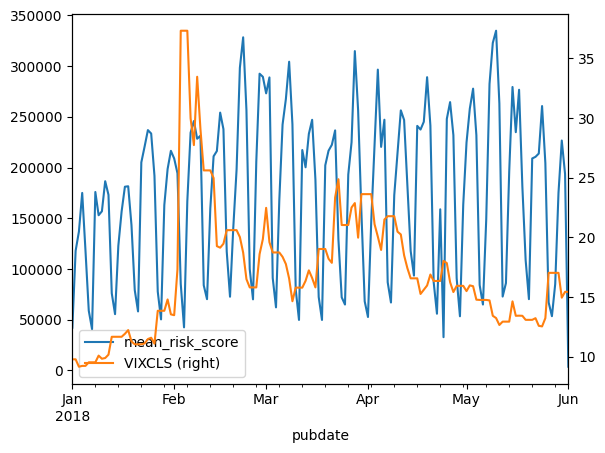

In [300]:
df_all2[['mean_risk_score', 'VIXCLS']].dropna().plot(style='-',secondary_y='VIXCLS')

#### Weekly

In [76]:
df_all4 = df_all2.resample('3W').sum()

In [80]:
df_all4.reset_index()

,pubdate,num_words_sum,num_words_count,risk_score_sum,VIXCLS,mean_risk_score
0,2018-01-01/2018-01-07,179449,11289,2.588576e+06,219.73,2.588576e+06
1,2018-01-22/2018-01-28,283671,14495,3.585783e+06,440.30,3.585783e+06
2,2018-02-12/2018-02-18,315786,15339,4.164272e+06,411.42,4.164272e+06
3,2018-03-05/2018-03-11,263561,13554,3.705579e+06,382.73,3.705579e+06
4,2018-03-26/2018-04-01,266709,15143,3.838136e+06,437.48,3.838136e+06
5,2018-04-16/2018-04-22,311524,14517,3.781872e+06,336.20,3.781872e+06
6,2018-05-07/2018-05-13,293223,14581,4.077234e+06,287.28,4.077234e+06
7,2018-05-28/2018-06-03,46401,2447,6.839855e+05,79.84,6.839855e+05


In [79]:
df_all4.index.to_timestamp()

DatetimeIndex(['2018-01-01', '2018-01-22', '2018-02-12', '2018-03-05',
               '2018-03-26', '2018-04-16', '2018-05-07', '2018-05-28'],
              dtype='datetime64[ns]', name='pubdate', freq='3W-MON')

In [302]:
df_all4[['mean_risk_score', 'VIXCLS']].dropna().corr()

,mean_risk_score,VIXCLS
mean_risk_score,1.000000,0.868171
VIXCLS,0.868171,1.000000


<Axes: xlabel='pubdate'>

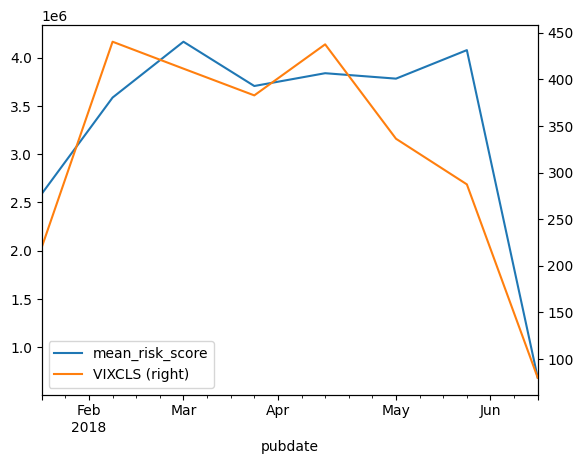

In [303]:
df_all4[['mean_risk_score', 'VIXCLS']].dropna().plot(style='-',secondary_y='VIXCLS')